In [1]:
import itertools
import warnings
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import BLD, SRC
from src.estimation.gridsearch import (
    get_mask_around_diagonal,
    run_1d_gridsearch,
    run_2d_gridsearch,
)
from src.estimation.msm_criterion import (
    get_index_bundles,
    get_parallelizable_msm_criterion,
)
from src.manfred.shared import hash_array
from src.plotting.msm_plots import plot_estimation_moment, plot_infection_channels
from src.simulation.load_params import load_params
from src.simulation.load_simulation_inputs import load_simulation_inputs

DEBUG = True
FALL_SIM_START = pd.Timestamp("2020-09-15")
FALL_SIM_END = pd.Timestamp("2020-12-22")
SPRING_SIM_START = pd.Timestamp("2021-02-05")
SPRING_SIM_END = pd.Timestamp("2021-02-28")
if DEBUG:
    FALL_SIM_END = FALL_SIM_START + pd.Timedelta(days=5)
    SPRING_SIM_END = SPRING_SIM_START + pd.Timedelta(days=5)

warnings.filterwarnings(
    "ignore", message="indexing past lexsort depth may impact performance."
)
%load_ext snakeviz

# Load the simulation inputs

In [2]:
params = load_params("baseline")

pmsm = get_parallelizable_msm_criterion(
    prefix="gridsearch",
    fall_start_date=FALL_SIM_START,
    fall_end_date=FALL_SIM_END,
    spring_start_date=SPRING_SIM_START,
    spring_end_date=SPRING_SIM_END,
    mode="fall",
    debug=DEBUG,
)

# Modify Params

In [3]:
index_bundles = get_index_bundles(params)
hh_probs = index_bundles["hh"]
school_probs = index_bundles["school"]
young_educ_probs = index_bundles["young_educ"]
work_probs = index_bundles["work"]
other_probs = index_bundles["other"]

vacation_probs = params.query("category == 'additional_other_vacation_contact'").index
free_probs = [bundle[0] for bundle in list(index_bundles.values()) + [vacation_probs]]

In [4]:
params.loc[other_probs, "value"] = 0.145
params.loc[young_educ_probs, "value"] = 0.01
params.loc[school_probs, "value"] = 0.01
params.loc[work_probs, "value"] = 0.155
params.loc[hh_probs, "value"] = 0.09
params.loc[vacation_probs, "value"] = 0.3
params.loc[free_probs]

value
category                          subcategory         name                      
infection_prob                    educ_school_0       educ_school_0        0.010
                                  educ_preschool_0    educ_preschool_0     0.010
                                  households          households           0.090
                                  work_non_recurrent  work_non_recurrent   0.155
                                  other_non_recurrent other_non_recurrent  0.145
additional_other_vacation_contact probability         Winterferien         0.300

In [5]:
params

value
category           subcategory        name                             
infection_prob     households         households                   0.09
                   educ_school_0      educ_school_0                0.01
                   educ_school_1      educ_school_1                0.01
                   educ_school_2      educ_school_2                0.01
                   educ_preschool_0   educ_preschool_0             0.01
...                                                                 ...
rapid_test_demand  hh_member_demand   2025-12-31                   0.75
                   reaction           hh_contacts_multiplier       0.70
                                      not_hh_contacts_multiplier   0.15
seasonality_effect seasonality_effect weak                         0.15
                                      strong                       0.25

[802 rows x 1 columns]

# Run estimation

In [6]:
dimensions = "1d"

n_gridpoints = 2
loc1 = work_probs
gridspec1 = (0.145, 0.155, n_gridpoints)
# only used if 2d
loc2 = other_probs
gridspec2 = (0.145, 0.155, n_gridpoints)

n_seeds = 2
n_cores = 4

mask = get_mask_around_diagonal(n_gridpoints, offset=1)
mask

array([[ True,  True],
       [ True,  True]])

In [7]:
if dimensions == "2d":
    results, grid, best_index, fig = run_2d_gridsearch(
        func=pmsm,
        params=params,
        loc1=loc1,
        gridspec1=gridspec1,
        loc2=loc2,
        gridspec2=gridspec2,
        n_seeds=n_seeds,
        n_cores=n_cores,
        mask=mask,
    )
else:
    results, grid, best_index, fig = run_1d_gridsearch(
        func=pmsm,
        params=params,
        loc=loc1,
        gridspec=gridspec1,
        n_seeds=n_seeds,
        n_cores=n_cores,
    )

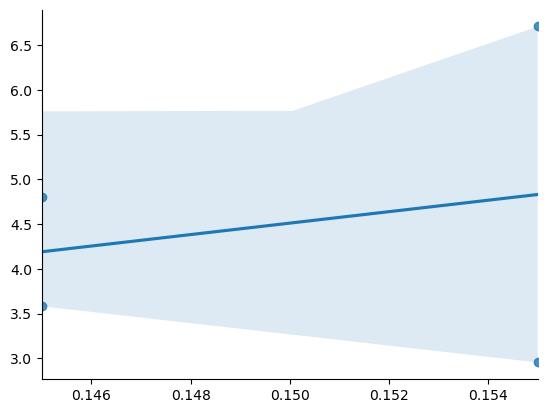

In [8]:
plt.show()

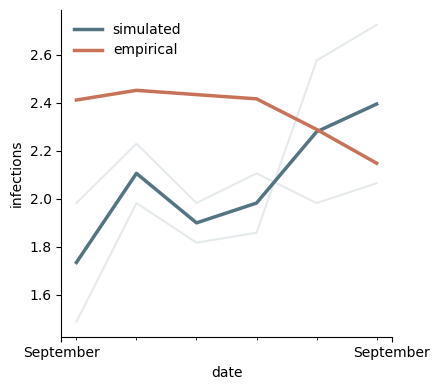

In [9]:
plot_estimation_moment(results[best_index], "aggregated_infections")

In [10]:
# plot_infection_channels(results[best_index], aggregate=True)

In [11]:
grid[best_index]

0.145

In [12]:
best_index

0

In [13]:
np.mean([res["value"] for res in results[best_index]])
# 28.13

4.190215128083586